# **Importer les packages et données**

In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
df_train=pd.read_csv('adult_train.csv')
df_test=pd.read_csv('adult_test.csv')

# **Nettoyage des données**

In [ ]:
#supprimer les espaces blancs au début et à la fin de chaque chaîne de caractères.
df_train[df_train.select_dtypes(include='object').columns] = df_train.select_dtypes(include='object').apply(lambda col: col.str.strip())
df_test[df_test.select_dtypes(include='object').columns] = df_test.select_dtypes(include='object').apply(lambda col: col.str.strip())

In [ ]:
# Trouver toutes les lignes dupliquées
duplicates = df_train[df_train.duplicated(keep=False)]  # Récupérer toutes les lignes dupliquées
# Compter les doublons exacts
print(f"Nombre total de lignes complètement identiques : {len(duplicates)}")

Nombre total de lignes complètement identiques : 47


In [ ]:
# Supprimer les doublons dans df_train
df_train_cleaned = df_train.drop_duplicates()
# Vérifier le nombre de lignes après suppression
print(f"Nombre de lignes avant suppression des doublons : {len(df_train)}")
print(f"Nombre de lignes après suppression des doublons : {len(df_train_cleaned)}")

Nombre de lignes avant suppression des doublons : 32561
Nombre de lignes après suppression des doublons : 32537


In [ ]:
# Trouver toutes les lignes dupliquées
duplicates = df_test[df_test.duplicated(keep=False)]  # Récupérer toutes les lignes dupliquées
# Compter les doublons exacts
print(f"Nombre total de lignes complètement identiques : {len(duplicates)}")

Nombre total de lignes complètement identiques : 10


In [ ]:
# Supprimer les doublons exacts
df_test_cleaned = df_test.drop_duplicates()
print(f"Taille après suppression des doublons : {df_test_cleaned.shape}")

Taille après suppression des doublons : (16276, 15)


### **Vérifier les valeurs manquantes.**

In [ ]:
# Vérifier la présence de '?' dans chaque colonne
for column in df_train_cleaned.columns:
    if df_train_cleaned[column].dtype == 'object':  # Vérifier uniquement les colonnes qualitatives
        missing_count = (df_train_cleaned[column] =='?').sum()
        if missing_count > 0:
            print(f"Colonne '{column}' contient {missing_count} valeurs manquantes ('?').")

Colonne 'workclass' contient 1836 valeurs manquantes ('?').
Colonne 'occupation' contient 1843 valeurs manquantes ('?').
Colonne 'native-country' contient 582 valeurs manquantes ('?').


In [ ]:
# Vérifier la présence de '?' dans chaque colonne
for column in df_test_cleaned.columns:
    if df_test_cleaned[column].dtype == 'object':  # Vérifier uniquement les colonnes qualitatives
        missing_count = (df_test_cleaned[column] =='?').sum()
        if missing_count > 0:
            print(f"Colonne '{column}' contient {missing_count} valeurs manquantes ('?').")

Colonne 'workclass' contient 963 valeurs manquantes ('?').
Colonne 'occupation' contient 966 valeurs manquantes ('?').
Colonne 'native-country' contient 274 valeurs manquantes ('?').


**Observation:**

Bien que le jeu de données ne contienne aucune valeur nulle,:il y a beaucoup de valeurs **'?'** (un symbole utilisé pour indiquer des valeurs manquantes ) dans le jeu de données. Nous allons devoir remplacer ces valeurs ! **ce qui facilite ensuite les opérations de nettoyage et de traitement des données**.

In [ ]:
# Remplacer '?' par NaN (NaN est l'indicateur de valeur manquante en pandas)
df_train_cleaned = df_train_cleaned.replace('?', pd.NA)
df_test_cleaned = df_test_cleaned.replace('?', pd.NA)

In [ ]:
# Imputer les valeurs manquantes dans les colonnes spécifiques avec la valeur la plus fréquente
for col in ['workclass', 'occupation', 'native-country']:
    df_train_cleaned[col] = df_train_cleaned[col].fillna(df_train_cleaned[col].mode()[0])

In [ ]:
# Imputer les valeurs manquantes dans les colonnes spécifiques avec la valeur la plus fréquente
for col in ['workclass', 'occupation', 'native-country']:
    df_test_cleaned[col] = df_test_cleaned[col].fillna(df_test_cleaned[col].mode()[0])
# Afficher les premières lignes pour vérifier
print(df_test_cleaned.head())

   age  workclass  Unnamed: 2     education  education-num  \
0   25    Private      226802          11th              7   
1   38    Private       89814       HS-grad              9   
2   28  Local-gov      336951    Assoc-acdm             12   
3   44    Private      160323  Some-college             10   
4   18    Private      103497  Some-college             10   

       marital-status         occupation relationship   race     sex  \
0       Never-married  Machine-op-inspct    Own-child  Black    Male   
1  Married-civ-spouse    Farming-fishing      Husband  White    Male   
2  Married-civ-spouse    Protective-serv      Husband  White    Male   
3  Married-civ-spouse  Machine-op-inspct      Husband  Black    Male   
4       Never-married     Prof-specialty    Own-child  White  Female   

   capital-gain  capital-loss  hours-per-week native-country  Income  
0             0             0              40  United-States  <=50K.  
1             0             0              50  Unite

**Exemple:**
La valeur **Private** a été choisie pour l'imputation car elle **est la plus fréquente dans la colonne Workclass**.

In [ ]:
df_train_cleaned = df_train_cleaned.drop(['education'], axis=1)
df_test_cleaned = df_test_cleaned.drop(['education'], axis=1)

In [ ]:
df_train_cleaned.loc[:, 'Income'] = df_train_cleaned['Income'].map({'<=50K': 0, '>50K': 1})
df_test_cleaned.loc[:, 'Income'] = df_test_cleaned['Income'].map({'<=50K.': 0, '>50K.': 1})

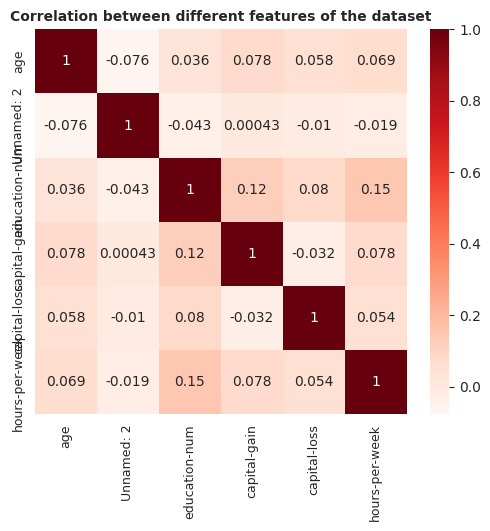

In [ ]:
# Sélectionner uniquement les colonnes numériques
numeric_df = df_train_cleaned.select_dtypes(include=['float64', 'int64'])
# Créer la matrice de corrélation
corr_matrix = numeric_df.corr()
# Afficher la heatmap
plt.figure(figsize = (6, 5))
plt.title("Correlation between different features of the dataset", fontsize = 10, fontweight = 'bold')
sns.heatmap(corr_matrix, cmap = 'Reds' , annot = True)
plt.xticks(fontsize=9, rotation = 90)
plt.yticks(fontsize=9, rotation = 90)
plt.show()

In [ ]:
df_train_cleaned=df_train_cleaned.drop(columns=['Unnamed: 2'])
df_test_cleaned=df_test_cleaned.drop(columns=['Unnamed: 2'])

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Vérifier si la colonne 'Income' est de type numérique, sinon la convertir
if df_train_cleaned['Income'].dtype != 'int64' and df_train_cleaned['Income'].dtype != 'float64':
    df_train_cleaned['Income'] = df_train_cleaned['Income'].astype(int)

# Séparer les variables numériques
X_numeric = df_train_cleaned.select_dtypes(include=['float64', 'int64']).drop(columns=['Income'], errors='ignore')

# Séparer les variables catégoriques
X_categorical = df_train_cleaned.select_dtypes(include=['object'])

# Concaténer les deux parties
X = pd.concat([X_numeric, X_categorical], axis=1)

# Extraire la variable cible
y = df_train_cleaned['Income']

# Rééquilibrer les données avec RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Créer un DataFrame équilibré
df_train_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_train_balanced['Income'] = y_resampled


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Dans ce bloc, nous avons vérifié que la variable "income" était numérique, encodé les variables catégorielles, puis concaténé les données. Pour l'équilibrage des classes, nous avons utilisé la méthode RandomSampleOver, qui duplique aléatoirement les exemples de la classe minoritaire pour égaliser les effectifs des deux classes.


In [ ]:
from imblearn.over_sampling import RandomOverSampler
# Vérifier si la colonne 'Income' est de type numérique, sinon la convertir
if df_test_cleaned['Income'].dtype != 'int64' and df_test_cleaned['Income'].dtype != 'float64':
    df_test_cleaned['Income'] = df_test_cleaned['Income'].astype(int)

# Séparer les variables numériques
X_test_numeric = df_test_cleaned.select_dtypes(include=['float64', 'int64']).drop(columns=['Income'], errors='ignore')

# Séparer les variables catégoriques
X_test_categorical = df_test_cleaned.select_dtypes(include=['object'])

# Concaténer les deux parties
X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)

# Extraire la variable cible
y_test = df_test_cleaned['Income']

# Rééquilibrer les données avec RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

# Créer un DataFrame équilibré
df_test_balanced = pd.DataFrame(X_test_resampled, columns=X_test.columns)
df_test_balanced['Income'] = y_test_resampled

# Vérification des dimensions
print(f"Taille avant équilibrage : {df_test_cleaned.shape}")
print(f"Taille après équilibrage : {df_test_balanced.shape}")

Taille avant équilibrage : (16276, 13)
Taille après équilibrage : (24860, 13)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


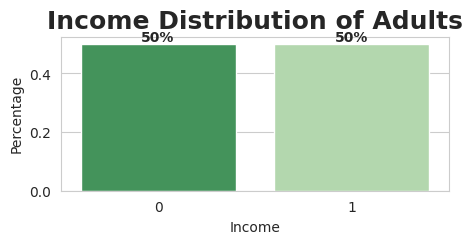

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize = (5, 2))
plt.title('Income Distribution of Adults', fontsize=18, fontweight='bold')
# Calculer la répartition par pourcentage de la colonne 'Income'
eda_percentage = df_train_balanced['Income'].value_counts(normalize=True).rename_axis('Income').reset_index(name='Percentage')
# Tracer le graphique avec 'hue' pour éviter l'avertissement
ax = sns.barplot(x='Income', y='Percentage', data=eda_percentage.head(10), palette='Greens_r', hue='Income', legend=False)
# Ajouter les annotations
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.0%}', (x + width/2, y + height*1.02), ha='center', fontweight='bold')
plt.show()

Examinons les test d'independence:

In [ ]:
# Importer mannwhitneyu de scipy.stats
from scipy.stats import mannwhitneyu
# Identifier les colonnes numériques
numeric_columns = df_train_balanced.select_dtypes(include=['float64', 'int64']).drop(columns=['Income']).columns
# Calcul des p-values pour chaque colonne numérique
for col in numeric_columns:
    group0 = df_train_balanced[df_train_balanced['Income'] == 0][col]
    group1 = df_train_balanced[df_train_balanced['Income'] == 1][col]
    # Test de Mann-Whitney
    _, p_value = mannwhitneyu(group0, group1)
    print(f"p-value de Mann-Whitney pour {col} : {p_value:.4f}")

p-value de Mann-Whitney pour age : 0.0000
p-value de Mann-Whitney pour education-num : 0.0000
p-value de Mann-Whitney pour capital-gain : 0.0000
p-value de Mann-Whitney pour capital-loss : 0.0000
p-value de Mann-Whitney pour hours-per-week : 0.0000


In [ ]:
from scipy.stats import kruskal
variables_qualitatives =df_train_balanced.select_dtypes(include=['object']).columns
# 2. Effectuer le test du kruskall centre chaque variable qualitative et la variable cible 'Income'
for col in variables_qualitatives:
  groups=[df_train_balanced[df_train_balanced[col]==cat]['Income'] for cat in df_train_balanced[col].unique()]
  stat, p = kruskal(*groups)
  print(f"kruskall wallis p-value pour {col}:{p:.5f}")

kruskall wallis p-value pour workclass:0.00000
kruskall wallis p-value pour marital-status:0.00000
kruskall wallis p-value pour occupation:0.00000
kruskall wallis p-value pour relationship:0.00000
kruskall wallis p-value pour race:0.00000
kruskall wallis p-value pour sex:0.00000
kruskall wallis p-value pour native-country:0.00000


Les tests statistiques (**Mann-Whitney pour les variables numériques et Kruskal-Wallis pour les variables catégorielles**)
ont montré des p-values égales à 0.0000, indiquant des différences significatives entre les groupes (income=0 et income=1).
Ces résultats confirment une forte dépendance entre la variable cible et les variables explicatives.

In [ ]:
# Identifier les colonnes numériques et catégoriques pour l'ensemble d'entraînement
numeric_features_train = df_train_balanced.select_dtypes(include=['int64', 'float64']).drop(columns=['Income']).columns
categorical_features_train = df_train_balanced.select_dtypes(include=['object']).columns
# Identifier les colonnes numériques et catégoriques pour l'ensemble de test
numeric_features_test = df_test_balanced.select_dtypes(include=['int64', 'float64']).drop(columns=['Income'], errors='ignore').columns
categorical_features_test = df_test_balanced.select_dtypes(include=['object']).columns
# Vérification que les colonnes sont cohérentes entre train et test
assert list(numeric_features_train) == list(numeric_features_test), "Les colonnes numériques ne correspondent pas entre train et test."
assert list(categorical_features_train) == list(categorical_features_test), "Les colonnes catégoriques ne correspondent pas entre train et test."

 ***Prétraitement des données***

In [ ]:
# Préparer le préprocesseur pour les colonnes numériques et catégoriques
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features_train),  # Standardisation des colonnes numériques
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_train)  # Encodage des colonnes catégoriques
])
# Préparer le préprocesseur pour les colonnes numériques et catégoriques
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features_test),  # Standardisation des colonnes numériques
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_test)  # Encodage des colonnes catégoriques
])

**StandardScaler**: Pour normaliser les colonnes numériques.

**OneHotEncoder** : Pour convertir les colonnes catégoriques en variables numériques.

In [ ]:
# Définir X (caractéristiques) et y (variable cible) pour l'entraînement
X_train = df_train_balanced.drop(columns=['Income'])
y_train = df_train_balanced['Income']
# Définir X (caractéristiques) et y (variable cible) pour le test
X_test = df_test_balanced.drop(columns=['Income'])
y_test = df_test_balanced['Income']
print("Dimensions des ensembles :")
print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

Dimensions des ensembles :
X_train : (49396, 12)
y_train : (49396,)
X_test : (24860, 12)
y_test : (24860,)


 **Construction du pipeline avec le modèle**

In [ ]:
# Construire le pipeline avec le modèle DecisionTreeClassifier
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))
])

Ce code construit une pipeline qui combine le prétraitement des données et l'entraînement d'un modèle d'arbre de décision.
La pipeline applique d'abord les transformations définies dans 'preprocessor' (comme la standardisation ou l'encodage),
puis entraîne un DecisionTreeClassifier avec une profondeur maximale de 5. Cela permet de structurer le flux de travail
tout en évitant les fuites de données (data leakage) en appliquant les transformations uniquement aux données d'entraînement.


**Entraînement du modèle**

In [ ]:
# Entraîner le modèle
clf.fit(X_train, y_train)
# Afficher le score d'entraînement
print(f"Score du modèle (entraînement) : {clf.score(X_train, y_train):.3f}")

Score du modèle (entraînement) : 0.815


**Évaluation du modèle**

In [ ]:
# Score sur l'ensemble de test
print(f"Score du modèle (test) : {clf.score(X_test, y_test):.3f}")
# Calcul des prédictions
y_pred = clf.predict(X_test)

Score du modèle (test) : 0.810


Le modèle montre une performance satisfaisante, avec un score de 81,5 % sur les données d'entraînement et 81,0 % sur les données de test. Ces résultats indiquent que le modèle est équilibré, c'est-à-dire qu'il généralise bien aux nouvelles données sans présenter de signes importants de surapprentissage (overfitting) ou de sous-apprentissage (underfitting).

**Courbe ROC**

Modèle aléatoire : ROC AUC=0.500
DecisionTreeClassifier : ROC AUC=0.892


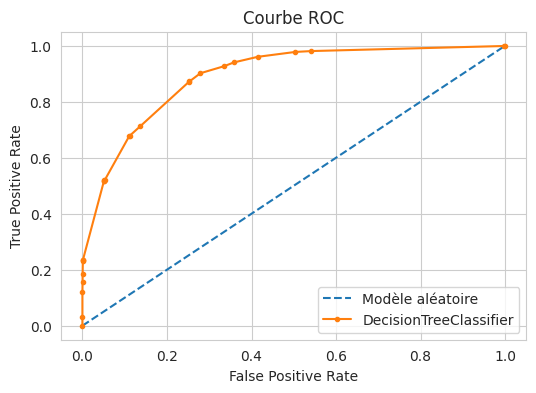

0.8915532937790323

In [ ]:
# Fonction pour tracer la courbe ROC
def drawRocCurve(classifier, nameClassifier, X_test, y_test):
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = classifier.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive
    # Calculer l'AUC
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    print(f"Modèle aléatoire : ROC AUC={ns_auc:.3f}")
    print(f"{nameClassifier} : ROC AUC={lr_auc:.3f}")
    # Tracer les courbes ROC
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Modèle aléatoire')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=nameClassifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('Courbe ROC')
    plt.show()
    return lr_auc
# Tracer la courbe ROC
drawRocCurve(clf, "DecisionTreeClassifier", X_test,y_test)

**La courbe ROC** (Receiver Operating Characteristic) compare les performances **du modèle aléatoire** (représenté par la ligne en pointillés) et du **DecisionTreeClassifier** (représenté par la courbe orange).

Le modèle aléatoire a un AUC (Area Under Curve) égal à **0,500**, ce qui reflète une performance équivalente à des prédictions aléatoires.
En revanche, le modèle DecisionTreeClassifier affiche une AUC de **0,892**, **ce qui montre une excellente capacité à différencier les classes positives et négatives.**
La courbe orange est nettement au-dessus de la diagonale (ligne du modèle aléatoire), ce qui indique que le modèle possède une forte capacité de classification. Cette performance suggère qu'il est capable de bien séparer les observations positives des négatives tout en minimisant les erreurs de classification.

**En conclusion, l'AUC élevée et la forme de la courbe démontrent que le DecisionTreeClassifier est beaucoup plus efficace qu'un modèle aléatoire.**

**Matrice de confusion**

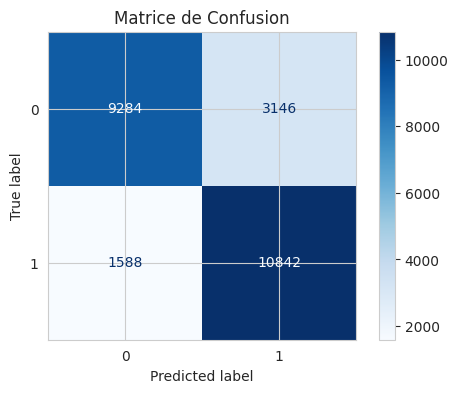

In [ ]:
# Afficher la matrice de confusion avec une taille plus petite
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Matrice de Confusion')
plt.show()

**Vrais positifs (True Positives, TP)** = 10 842
Cela signifie que le modèle a correctement prédit que 10 842 individus appartiennent à la classe 1.

**Faux négatifs (False Negatives, FN)** = 1 588
Cela signifie que 1 588 individus appartiennent réellement à la classe 1, mais que le modèle les a incorrectement prédits comme appartenant à la classe opposée (classe 0).

**Faux positifs (False Positives, FP)** = 3 146
Cela signifie que 3 146 individus ont été incorrectement prédits comme appartenant à la classe 1, alors qu'ils n'y appartiennent pas.

**Vrais négatifs (True Negatives, TN)** = 9 284
Cela signifie que le modèle a correctement identifié 9 284 individus appartiennent à la classe 0.



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Afficher les métriques de performance
print("Classification Report :")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

Classification Report :
              precision    recall  f1-score   support

       <=50K       0.85      0.75      0.80     12430
        >50K       0.78      0.87      0.82     12430

    accuracy                           0.81     24860
   macro avg       0.81      0.81      0.81     24860
weighted avg       0.81      0.81      0.81     24860



## Analyse des Résultats du Modèle

### Résumé des valeurs clés :
- **Précision pour la classe <=50K :** 0,85  
  Cela signifie que **85%** des individus prédits comme appartenant à cette classe sont correctement classés.

- **Rappel pour la classe <=50K :** 0,75  
  Cela indique que **75%** des individus qui appartiennent réellement à la classe **<=50K** ont été correctement identifiés par le modèle.

- **F1-Score pour la classe <=50K :** 0,80  
  Le F1-score est la moyenne harmonique entre la précision et le rappel. Ici, il est de **0,80**, ce qui indique un équilibre favorable.

---

- **Précision pour la classe >50K :** 0,78  
  Cela signifie que **78%** des individus prédits comme appartenant à cette classe sont correctement classés.

- **Rappel pour la classe >50K :** 0,87  
  Cela indique que **87%** des individus qui appartiennent réellement à la classe **>50K** ont été correctement identifiés par le modèle.

- **F1-Score pour la classe >50K :** 0,82  
  Le F1-score est de **0,82**, ce qui indique un équilibre positif entre précision et rappel pour cette classe.

---

### Mesures Globales :
- **Accuracy globale du modèle :** 0,81  
  Cela signifie que **81%** des prédictions du modèle sont correctes sur l'ensemble des données.

- **Macro Average :** 0,81  
  Cela donne une idée globale des performances du modèle sans prendre en compte la taille relative des deux classes.

- **Weighted Average :** 0,81  
  Le score moyen pondéré est cohérent avec l'accuracy globale.

---

## Conclusion
1. Le modèle est globalement performant avec une **accuracy de 81%**.
2. Le rappel est meilleur pour la classe **>50K** (0,87) que pour la classe **<=50K** (0,75), ce qui peut indiquer que le modèle a une meilleure capacité à identifier les individus dans la classe avec un revenu supérieur à 50K.
3. Les valeurs de précision montrent que la classe **<=50K** est prédite avec une meilleure précision, tandis que la classe **>50K** a un rappel légèrement inférieur.



# **Autre modèle**


Random Forest Classifier:
Accuracy: 0.7839501206757844
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.74      0.88      0.80     12430
        >50K       0.85      0.69      0.76     12430

    accuracy                           0.78     24860
   macro avg       0.80      0.78      0.78     24860
weighted avg       0.80      0.78      0.78     24860



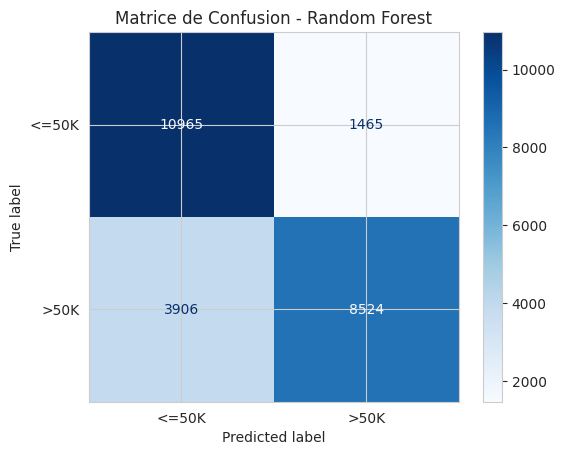

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Pipeline avec RandomForestClassifier
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
# Entraîner le modèle RandomForestClassifier
pipeline_rf.fit(X_train, y_train)

# Prédire avec RandomForestClassifier
y_pred_rf = pipeline_rf.predict(X_test)
print("\nRandom Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=['<=50K', '>50K']))
# Afficher la matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Afficher la matrice de confusion pour RandomForestClassifier
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['<=50K', '>50K']).plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion - Random Forest')
plt.show()

## Analyse des Résultats du Modèle - Random Forest Classifier

### Résumé des valeurs clés :
- **Accuracy globale :** 0,78  
  Cela signifie que le modèle est correct dans **78%** des cas sur l'ensemble des données.

---

### Résumé du Classification Report :

#### Pour la classe **`<=50K`** :
- **Précision = 0,74**  
  Cela indique que **74%** des prédictions pour cette classe sont correctes.  

- **Rappel = 0,88**  
  Cela signifie que le modèle a correctement identifié **88%** des individus appartenant réellement à la classe **`<=50K`**.

- **F1-Score = 0,80**  
  Cela reflète un équilibre harmonieux entre précision et rappel pour cette classe.

---

#### Pour la classe **`>50K`** :
- **Précision = 0,85**  
  Cela indique que **85%** des prédictions pour cette classe sont correctes.  

- **Rappel = 0,69**  
  Cela signifie que le modèle a correctement identifié **69%** des individus appartenant réellement à la classe **`>50K`**.

- **F1-Score = 0,76**  
  Cela montre un équilibre entre précision et rappel dans cette classe.

---

### Moyennes :
- **Macro Average :**  
  - Précision = 0,80  
  - Rappel = 0,78  
  - F1-Score = 0,78  

  La macro moyenne donne une vue globale des performances du modèle sur les deux classes sans tenir compte de la taille relative des classes.

- **Weighted Average :**  
  - Précision = 0,80  
  - Rappel = 0,78  
  - F1-Score = 0,78  

  La moyenne pondérée prend en compte la taille relative de chaque classe dans l'ensemble de données.

---

## Conclusion
1. **Précision et rappel équilibrés dans l'ensemble :**  
   Le modèle a un équilibre raisonnable, avec une précision globale de **0,80** et un rappel équilibré.

2. **Classe `<=50K` identifiée avec un rappel élevé (0,88), mais une précision plus faible (0,74).**  
   Cela peut suggérer que le modèle identifie bien les individus dans cette classe, mais certains faux positifs peuvent exister.

3. **Classe `>50K` avec une précision élevée de 0,85 mais un rappel plus faible (0,69).**  
   Cela indique que le modèle est confiant dans ses prédictions pour cette classe, mais peut manquer certains individus qui appartiennent réellement à cette classe.

## Conclusion
1. **Decision Tree Classifier :**  
   - Montre une meilleure performance globale en termes d'accuracy et de F1-Score.  
   - A une meilleure capacité à équilibrer précision et rappel.

2. **Random Forest Classifier :**  
   - Présente des valeurs similaires mais légèrement inférieures en comparaison avec Decision Tree Classifier.  
   - Moins efficace en termes de rappel global.

En général, **Decision Tree Classifier** est légèrement plus performant en termes de métriques globales. Toutefois, l'avantage de Random Forest est sa robustesse en évitant le surajustement grâce à la combinaison de plusieurs arbres de décision.

Pour une meilleure généralisation sur de nouveaux ensembles de données, Random Forest est souvent préféré en raison de sa nature d'agrégation (moyenne de plusieurs arbres).